# Greedy Algo Optimizer

In [1]:
import plbpy as plb
universe = plb.Universe()

In [6]:
import pandas as pd
import numpy as np

from plbpy.Research.Optimization import Portfolio 
from plbpy.Research.Optimization import Visualizer
from plbpy.Research.Optimization import GreedyOptimizer
from plbpy.Research.Optimization import calculator as calc
from plbpy.Research.Optimization import viz_calculator as vis_calc
import matplotlib.pyplot as plt


## 1. Introduction

This notebook provides a framework to select a basket of strategies from Premialab universe of over 3,000 strategies to overlay an existing portfolio according to the most complementary factors.

In the discussion below, the existing portfolio will be referred to as the _**Core Portfolio**_. The portfolio of strategies will be referred to as the _**Overlay Portfolio**_. The combination of the two will be referred to as the _**Optimized Portfolio**_.

User has the ability to specify the number of strategies in the **_Overlay Portfolio_**, the utility function and time period to optimise their selection.
 
The workflow is divided in a three-step approach to define the complementary factors to the Core Portfolio, then the actual strategies to form the **_Overlay Portfolio_**  and finally a forward looking **Black-Litterman** allocation model to assess the results.

### 1.1 Core Portfolio Creation
The user can create a core portfolio either by directly passing the timeseries of the constituents as a pandas dataframe or by specifying the tickers of the constituents. The latter works only if the portfolio consists of strategies in the Premialab database. Constiutuents weights can be passed with both methods.

In [3]:
prices = plb.universe.code(['SGIXESPU','SGEPLBU']).tracks(start='2021-01-01').to_frame().fillna(method='ffill')

In [4]:
weights={'SGIXESPU':0.4,'SGEPLBU':0.6}

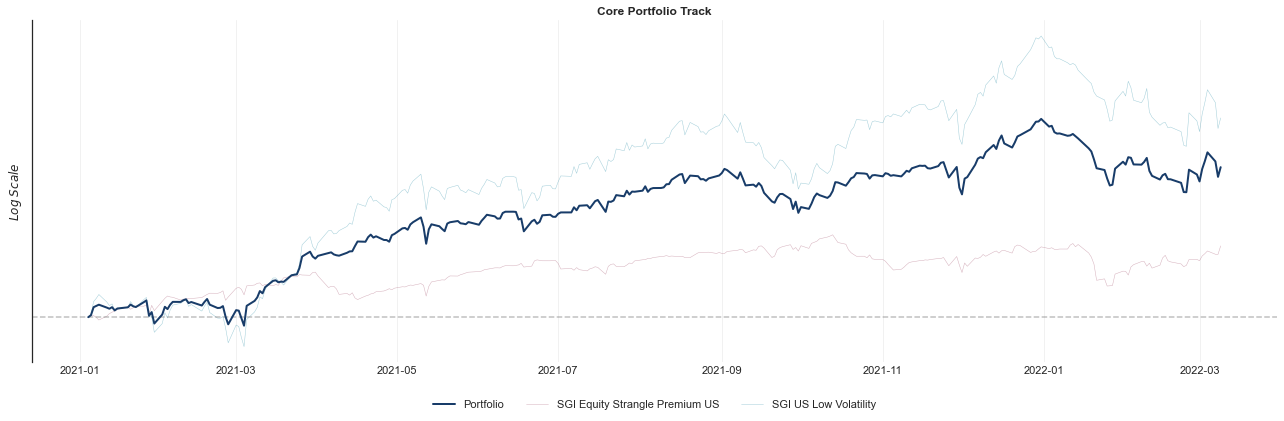

In [7]:
core = Portfolio(universe = prices, weights=weights)
vis_calc.visualize_track(core);

<hr>

## 2. Optimization

In order to make the optimization process efficient, we break up the optimisation process into **3 distinct steps**.
 
1. First, we select the **Premialab Pure Factors** that produce the best value of objective function (user-specified) when combined with the Core Portfolio.<br><br>
 
2. Next, we shall select the respective strategies corresponding to the asset class and factor group of each selected **Premialab Pure Factor** to compose the Overlay Portfolio.<br>
This selection shall be based on strategies that produce the best value of objective function (user-specified) when combined with the Core Portfolio. A correlation constraint is also added to ensure that each strategy provides diversification within the Overlay Portfolio and is sufficiently correlated to the **Premialab Pure Factors** targeted.<br>
All strategies are chosen iteratively in phases; each phase adding one strategy to the Core Portfolio that produces and overlay with the best objective function (user-specified) on calibration periods. More commonly, this is known as the **greedy search algorithm.**<br><br>
 
3. The final step in the optimisation process entails utilising a forward looking allocation model to construct the most optimal Overlay Portfolio: <br>**Black-Litterman Allocation (BL)**. It takes into account the user's subjective market outlook, their confidence in the outlook and historical returns (prior distribution) to compute a new set of expected returns for the portfolio (posterior distribution). The new returns are used to compute individual weights (see section 3.2 for more details).<br><br>

In [8]:
# best to store pure factor timeseries and your universe time series in plb.session.kwargs['pure_factor_tracks'] 
# and plb.session.kwargs['basket_tracks'] respectively (both dataframes) before setting up optimizer
# Then set optmizer with use_cache = True


##### OPTIMIZER SET UP



optimizer = GreedyOptimizer(core = core,
                      num_select = 3,
                      hedge_percent = 0.20,
                      max_correlation=0.2,
                      num_factors = 3,
                      objective='drawdown', 
                      use_cache=False, # best to store timeseries data in session.kwargs and switch use_cache "on"
                      universe_filter = plb.universe.type('Strategy').asset_class('Equity').region('US'))

### 2.1 Select Pure Factors
In the example below, we have selected a permutation of 5 Pure Factors that when that when added to the Core Portfolio produces the best info ratio.
Other conditions applied include:
- Weighting = 50% Core Portfolio + 50% Pure Factors (equally distributed across 3 PFs)
- Calibration period = 2016-10-30 to 2021-10-30

##### Final Selected 5 Pure Factors

In [9]:
optimizer.create_initial_basket()

Extracting tracks for 379 tickers. Batch #: 100%|█████████████████████████████████████████████████████| 8/8 [00:50<00:00,  6.31s/it]


In [10]:
optimizer.pure_factors

code                          short_name   provider  \
0  PLFEQVAUS     PLB Pure Factor Equity US Value  PremiaLab   
1  PLFEQCAUS     PLB Pure Factor Equity US Carry  PremiaLab   
2  PLFEQMOUS  PLB Pure Factor Equity US Momentum  PremiaLab   

  history_start_date currency         type  style    factor asset_class  \
0         2005-06-30      USD  Pure Factor  Alpha     Value      Equity   
1         2005-06-30      USD  Pure Factor  Alpha     Carry      Equity   
2         2005-06-30      USD  Pure Factor  Alpha  Momentum      Equity   

  region inception_date  index_source Return Volatility Information Ratio  
0     US     2005-06-30  PremiaLab V2   7.29       6.72              1.09  
1     US     2005-06-30  PremiaLab V2    3.1       4.77              0.65  
2     US     2005-06-30  PremiaLab V2  -9.83       9.76             -1.01

In [11]:
optimizer.summary()

1. Underlying strategies will be selected from following Pure Factors:
['PLFEQVAUS', 'PLFEQCAUS', 'PLFEQMOUS']
	Total number of stratgies: 32
	Number of strategies to be selected: 3 (user input)

2. Calibration Period:
['2021-01-04 to 2022-03-09']

3. Optimization Criteria:
	  Minimize Drawdown  of Overlay over calibration periods


### 2.2 Optimise weighting for strategies

Now that we have identified the strategies we want in the Hedge Portfolio, the final step in the optimisation process entails utilising the **Black-Litterman Allocation Model** to construct the most optimal Overlay Portfolio.<br>
 
Other conditions applied include:
- Each strategy needs to make up at least 5% of the Hedge Portfolio
- Conviction that UK Equity Market (FTSE 100) up 15% next year with high confidence level and Europe IG (Markit iBoxx Euro Liquid Corp) up 5% next year with moderate confidence

#### Selected Strategies and Optimized Weightings (BL)

In [12]:
optimzed = optimizer.run_optimizer()
round(optimzed.constituents_data().loc[np.setdiff1d(optimzed.tickers, core.tickers).tolist()][['short_name','weight','factor','asset_class','region']],3)

short_name  weight      factor asset_class  \
code                                                                           
MSPIATDA           MS US Target Equity Alpha   0.022       Value      Equity   
MSUSDBSP  MS SPX Daily Weekly Mean Reversion   0.104    Momentum      Equity   
MSUSEVHG                       MS eVol Hedge   0.073  Volatility      Equity   

         region  
code             
MSPIATDA     US  
MSUSDBSP     US  
MSUSEVHG     US

In [13]:
viz = Visualizer(optimzed,core)

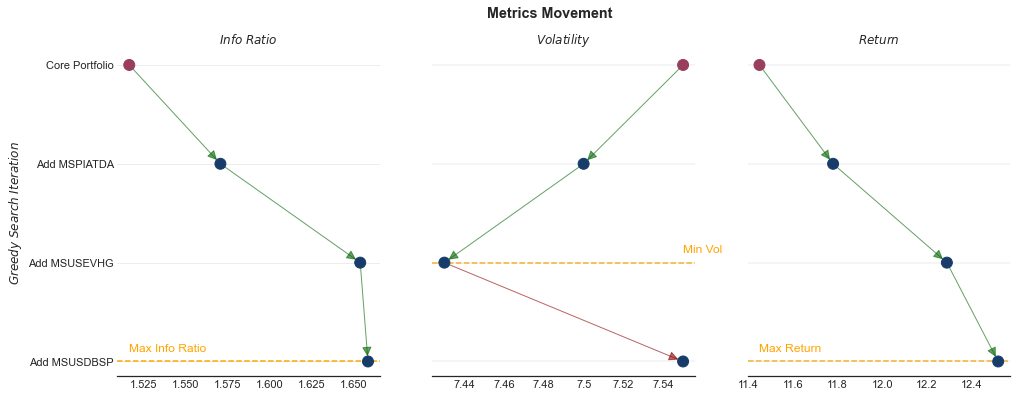

In [14]:
fig, ax = viz.metrics_movement()
plt.show()

#### Optimized Portfolio Metrics vs Core

In [15]:
ov = optimzed.metrics().copy()
ov.index=['Optimized']
c = core.metrics().copy()
c.index=['Core']
(round(ov.append(c),2))

Return  Return Cumulated  Volatility  Skew  Kurtosis  \
Optimized   12.52             14.87        7.58 -0.09      2.25   
Core        11.45             13.59        7.55 -0.15      2.05   

           Autocorrelation  Max Drawdown  Avg Drawdown  Sharpe Ratio  \
Optimized            -0.05         -5.75         -1.01          1.64   
Core                 -0.05         -6.12         -1.04          1.51   

           Information Ratio  Calmar Ratio  Omega Ratio  Sortino Ratio   VaR  \
Optimized               1.65          2.16         1.30           2.22  0.78   
Core                    1.52          1.86         1.28           2.02  0.77   

           CVaR  MVaR  Positive Weeks (%)  Positive Months (%)  
Optimized  1.09  0.73               61.29                66.67  
Core       1.10  0.74               66.13                60.00

### 2.3 Optimizer Initialization Summary
A summary of the input parameters that user has full flexibility on when it comes to strategies to be considered.
In order to initialize the optimizer, a user can pass up to 10 input parameters broadly categorised into 3 groups:<br>
- Parameters for Overlay Portfolio:
    1. **core (mandatory)**: The starting portfolio. This is the only compulsory input.
    2. **num_stratgies**: An integer for the number of strategies to be selected for hedge portfolio. _default value - 4_
    3. **hedge_percent**: A float specifying the hedge percentage. _default value - 0.15_
    4. **leverage**: Boolean value. True if the optimized portfolio needs to be leveraged, False for an unlevered optimized portfolio. _default value - True_
    5. **max_corr**: A float number specifying the maximum correlation tolerated between selected strategies.This is also the minimum correlation a strategy needs to have with its parent Pure Factor in order to be selected in the universe. _default value: 0.2_


- Parameters for Filtering the Universe:
    1. **pure_factors**: A list. User may select specific pure factors to initiate the optimization process. default value: All 45 Pure Factors
    2. **num_factors**: Alternatively, they can choose to take in the best performing Pure factors based on a user defined objective. _default value: 5_ <br>
    **Note**: User can only pass one of "pure_factors" "num_factors"


- Parameters for Optimization
    1. **period**: An nx2 numpy array where n represents calibration periods with a start and an end date.
    2. **objective**: The anchor upon which the optimizer selects the overlay portfolio. _default value: 'volatility'.... possible values: 'volatility', 'returns','drawdown','info ratio'_
    3. **view**: This is a list of opinions the user has on the market. Each element in this list follows the format: (ticker, outlook, confidence). For example, if a user believes that next year the US market will go up by 10% and is highly confident in their analysis, the view element will look like - ("SPX", 0.1, 2)

<hr>

## 3. Visualizations

### 3.1 Portfolio Level

Few graphs capturing the performance of the optimized portfolio vs core portfolio

In [16]:
fig = vis_calc.MST(optimizer, viz.hedge, core, start='2020-03-01')
fig.show()

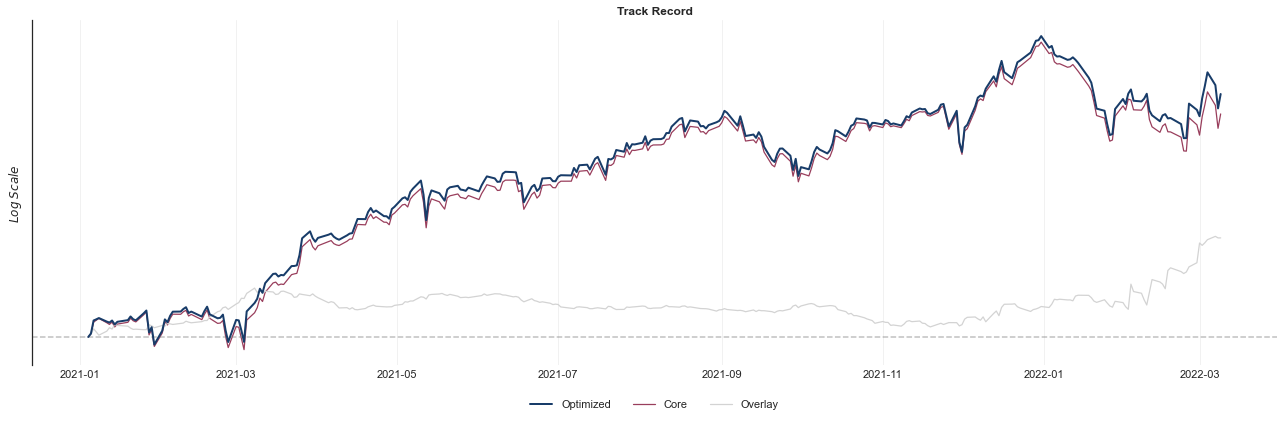

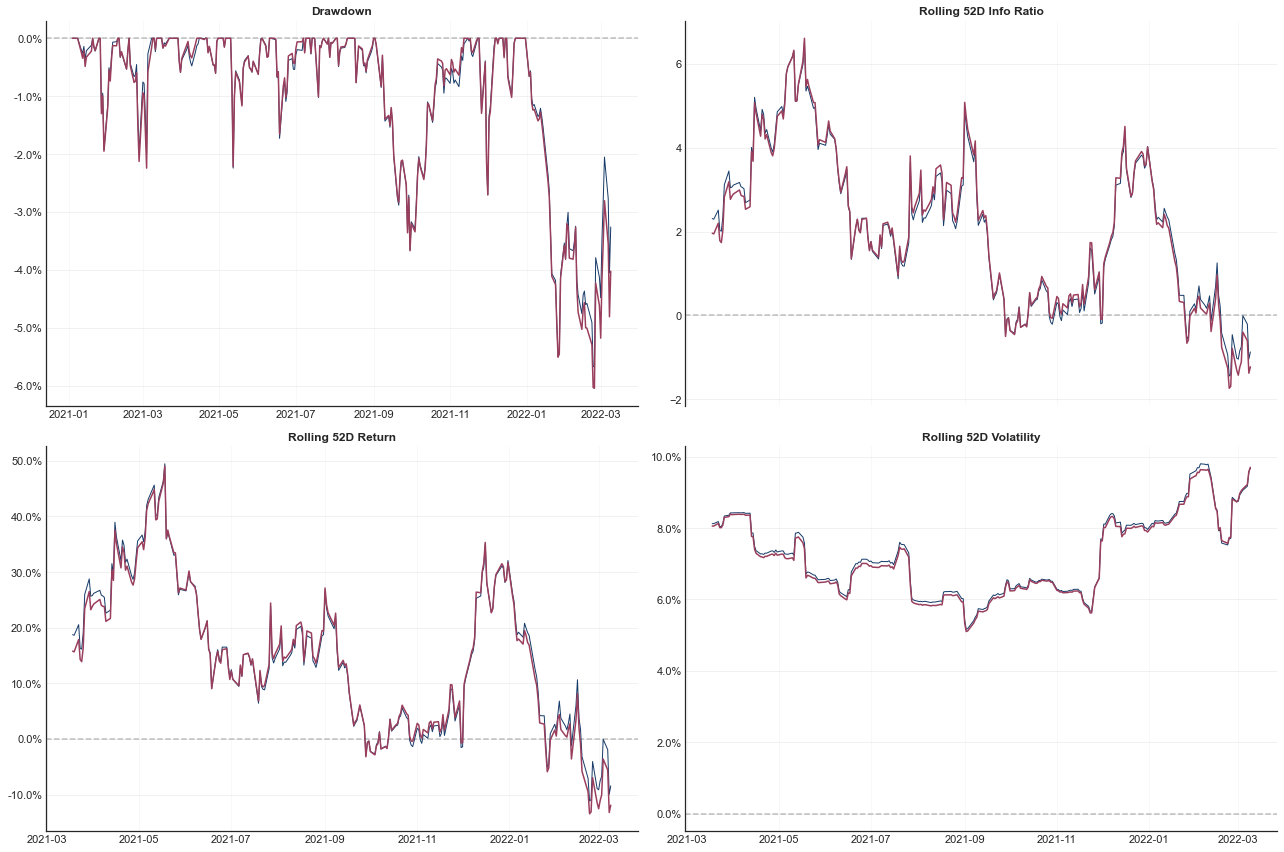

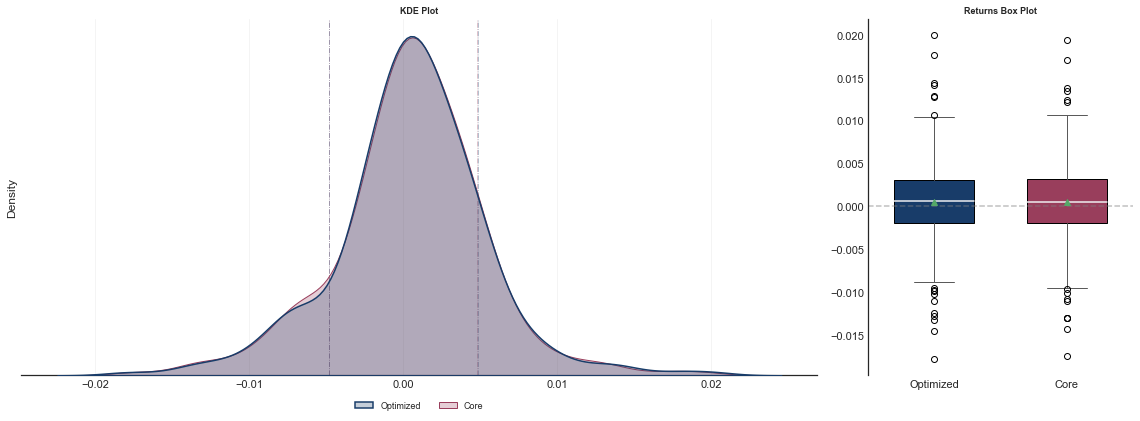

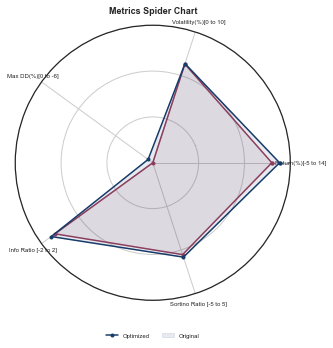

In [17]:
fig, ax = viz.track_record()
plt.show()

viz.other_overall_lines(rolling=52)
fig, ax  = viz.overall_kde_plot()

plt.show()
fig, ax  = viz.spider_chart()

plt.show()


### 3.2 Black Litterman Allocation Analysis
As mentioned above, the **Black Litterman Allocation (BL)** model has been used to adjust the weights of the selected hedge strategies. <br>
In technical terms, the BL model accepts a **prior estimate** of asset returns a portfolio, combines these with **views** on certain assets in order to produce a **posterior estimate** of returns for each asset of the portfolio. The fact that this model consideres a user's views/outlook/opinions of the performance of certain assets in the future makes this a **forward looking** model.

##### Views
The most striking feature of this model, views are the expectations that a user has for a given set of assets. The model considers the covariance of the given portfolio's constituents with the assets for which the user provides a view for. However, one can never be fully certain about the future, a user might want to have certain room for error in their views. The BL model caters to this by accepting a level of confidence for each view that the user has. The model then takes into account the user's certainty about their views in order to calculate the posterior returns.

- In this example, the views used are:
    1. **UK Equity to go up 15%** in the next year with a high confidence : confidence number is 2.5
    2. **Europe IG to rise 5%** with moderate confidence: confidence number is 1.
    
<span style='color: red; font-weight:bold'>Please note that these values are used solely for illustration purposes. </span>


##### Prior Estimate
This is an estimation of the returns that the user already holds i.e. the market-implied returns. For demonstration here, we use the **reverse optmimzed returns** of the selected overlay. The user can use any prior estimate. 


##### Outputs
The model will return the expected returns and the corresponding covariance matrix for each asset for which prior estimates are provided. These will be passed on to a **Mean Variance Optimizer** in order to generate an efficient frontier _(below)_ and subsequently find the most optimal weight for each strategy based on the user's objective function. <br>


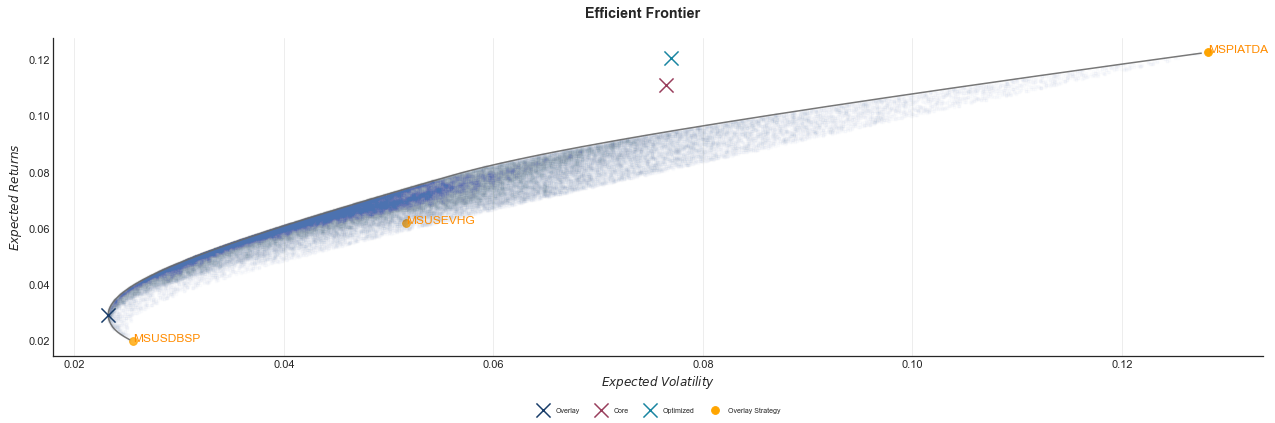

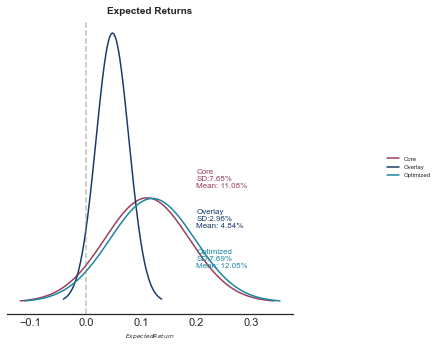

In [18]:
viz.bl_analysis()

### 3.3 Strategy Level Analysis
The following visualization breaks down the overlay portfolio into its constituents and represents their performances.

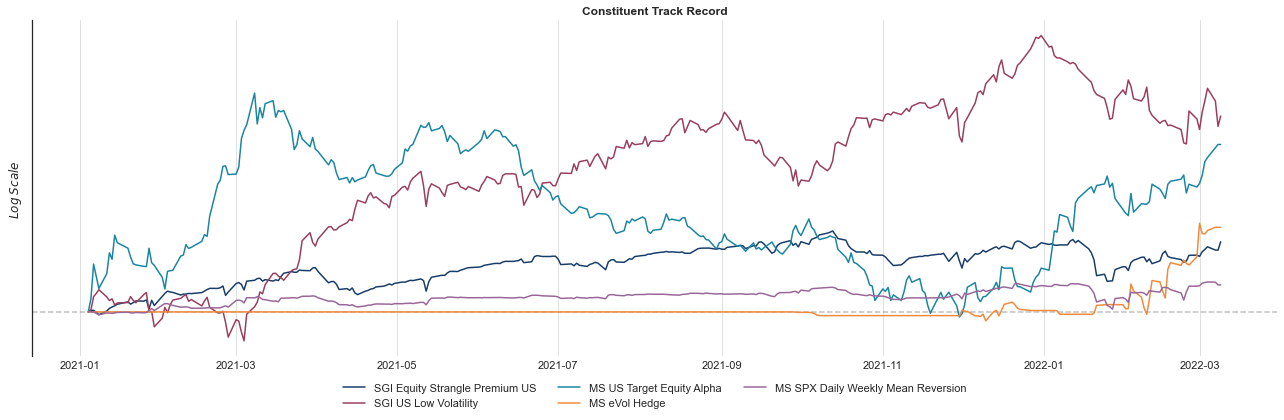

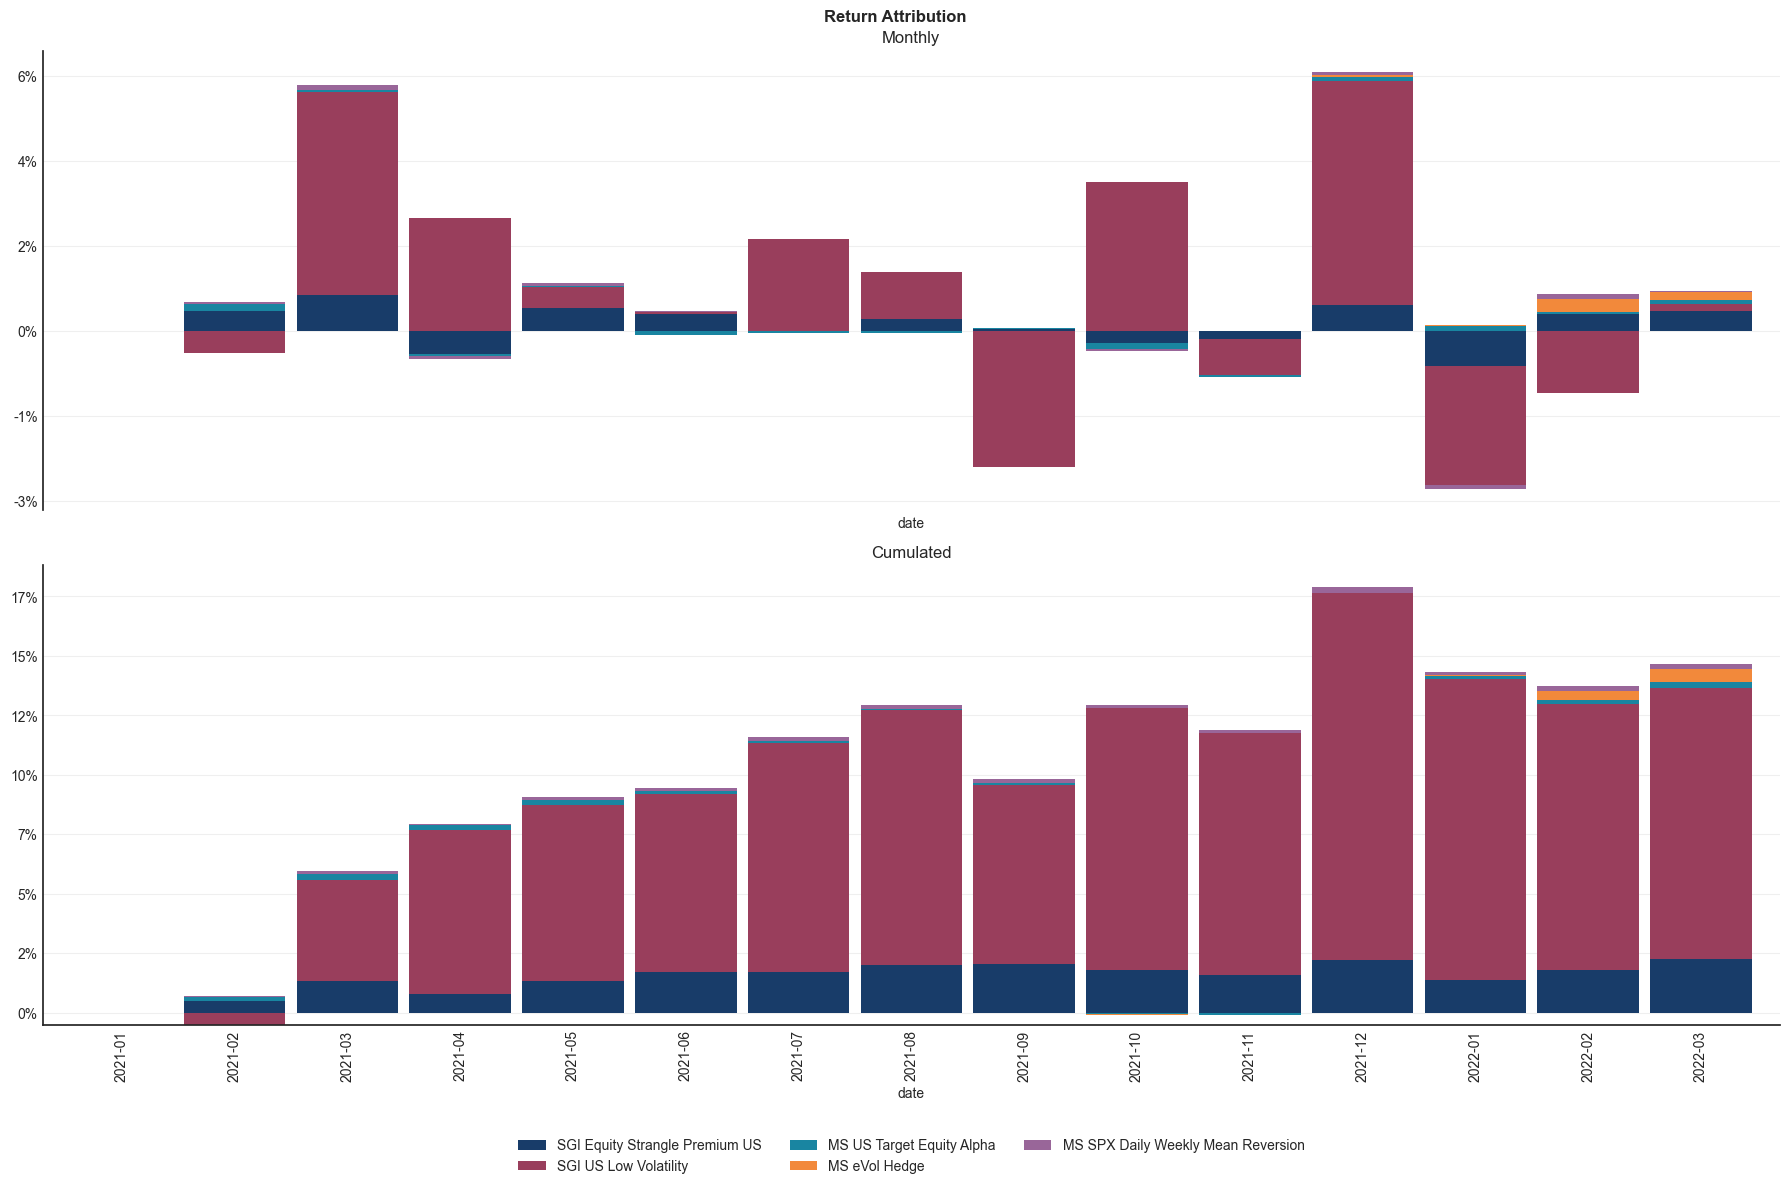

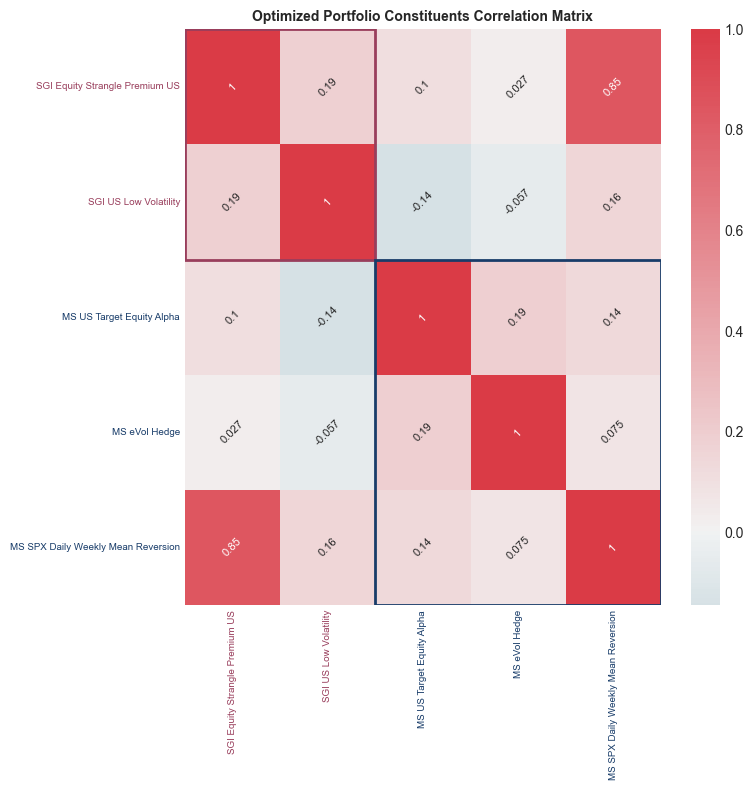

In [19]:
viz.constituents_analysis()

<hr>

<span style="font-size: 8pt; font-style:italic">This document is provided by PremiaLab HK Limited (“PremiaLab”) for registered users only and the access to the Services is restricted to Professional Investors as defined in the Terms and Conditions of www.PremiaLab.com. PremiaLab is providing access to documents and information regarding financial instruments or securities. PremiaLab is not related, nor associated to any of these instruments. Please refer to the corresponding sponsor or issuer for further information. The information contained herein are derived from proprietary models based upon well-recognized financial principles and from data that has been obtained from external sources believed reliable. However PremiaLab and any external information provider, disclaim any responsibility for the accuracy of estimates and models used in the calculations, any errors or omissions in computing any performance and statistic information. PremiaLab does not accept any liability whatsoever for any direct or consequential loss arising from any use of the information provided. Performance and statistic information is provided in this document solely for informational purposes and should not be interpreted as an indication of actual or future performance. This document does not constitute an offer, recommendation or solicitation for the purchase or sale of any particular financial instrument or any securities. PremiaLab does not provide legal advice or tax advice or investment advice nor does PremiaLab give any investment recommendation or financial analysis.</span>